# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [5]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

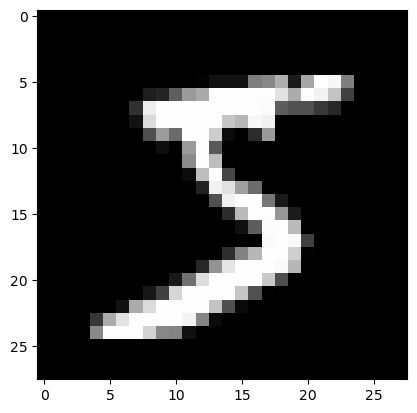

In [7]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

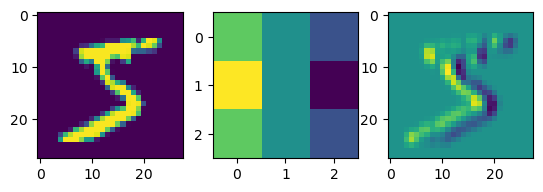

In [8]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/qb24/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [12]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

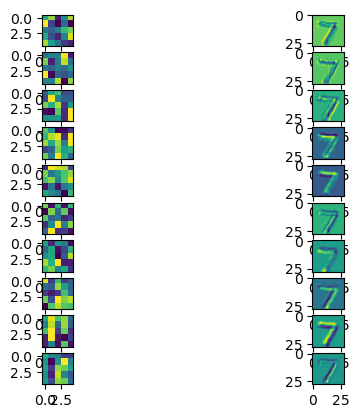

In [13]:
visualize()

# Predict Using Network

In [14]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [15]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([7, 0, 1, 1, 1])

# First Test and Train

In [16]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [17]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 11%



In [18]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [19]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.344622
Train loss: 2.089417
Train loss: 1.133935
Train loss: 0.994557
Train loss: 0.645501
Train loss: 0.652231
Train loss: 0.433543
Train loss: 0.550690
Train loss: 0.643927
Train loss: 0.490603


# Train Network

In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.297860
Train loss: 2.086694
Train loss: 1.348339
Train loss: 1.035067
Train loss: 0.526980
Train loss: 0.627104
Train loss: 0.664476
Train loss: 0.516478
Train loss: 0.427848
Train loss: 0.625769
Test accuracy: 94%

Train loss: 0.337999
Train loss: 0.406285
Train loss: 0.335038
Train loss: 0.645718
Train loss: 0.240833
Train loss: 0.523600
Train loss: 0.301060
Train loss: 0.473872
Train loss: 0.381144
Train loss: 0.240271
Test accuracy: 96%

Train loss: 0.207265
Train loss: 0.416563
Train loss: 0.226458
Train loss: 0.521026
Train loss: 0.222326
Train loss: 0.320325
Train loss: 0.229229
Train loss: 0.360940
Train loss: 0.429802
Train loss: 0.427638
Test accuracy: 97%

Train loss: 0.209879
Train loss: 0.251740
Train loss: 0.212485
Train loss: 0.323129
Train loss: 0.194505
Train loss: 0.244215
Train loss: 0.197486
Train loss: 0.209416
Train loss: 0.456902
Train loss: 0.330279
Test accuracy: 97%

Train loss: 0.153327
Train loss: 0.192187
Train loss: 0.133151
Train loss: 0.389

# Inspect Network

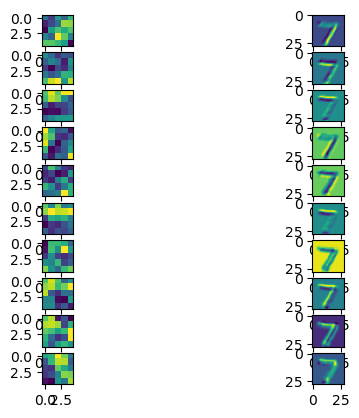

In [21]:
visualize()

In [22]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [23]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# Homework 

- 1a. What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?

In [24]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [25]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.325762
Train loss: 1.904974
Train loss: 0.881882
Train loss: 0.944209
Train loss: 0.889162
Test accuracy: 90%

Train loss: 0.781594
Train loss: 0.443205
Train loss: 0.535674
Train loss: 0.591851
Train loss: 0.347675
Test accuracy: 94%

Train loss: 0.364794
Train loss: 0.271026
Train loss: 0.226392
Train loss: 0.484036
Train loss: 0.324522
Test accuracy: 96%

Train loss: 0.495002
Train loss: 0.315747
Train loss: 0.266604
Train loss: 0.386625
Train loss: 0.210862
Test accuracy: 96%

Train loss: 0.346657
Train loss: 0.256057
Train loss: 0.273992
Train loss: 0.297786
Train loss: 0.202203
Test accuracy: 96%



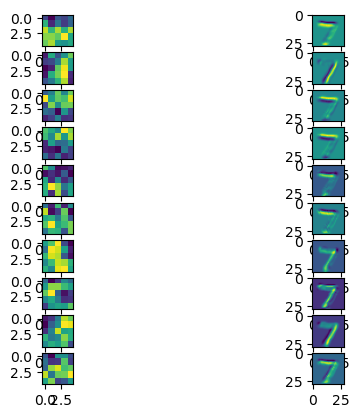

In [26]:
visualize()

Using 30,000 images instead of 60,000 decreases the accuracy only slightly - going from a maximum accuracy of 98% to 96%.

In [27]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [28]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.313293
Test accuracy: 71%

Train loss: 1.870909
Test accuracy: 84%

Train loss: 1.002075
Test accuracy: 89%

Train loss: 0.722218
Test accuracy: 91%

Train loss: 0.667251
Test accuracy: 91%



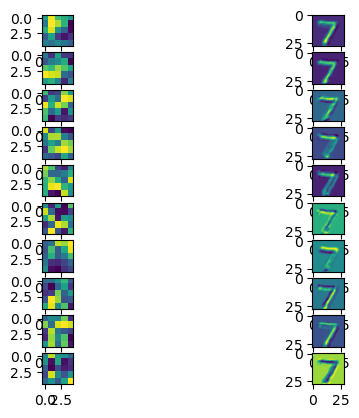

In [29]:
visualize()

Using 6,000 images instead of 60,000 decreases the accuracy quite a bit more - going from a maximum accuracy of 98% to 91%. 

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [31]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.292690
Test accuracy: 26%

Train loss: 2.273078
Test accuracy: 43%

Train loss: 2.138695
Test accuracy: 62%

Train loss: 1.826398
Test accuracy: 72%

Train loss: 1.508860
Test accuracy: 83%



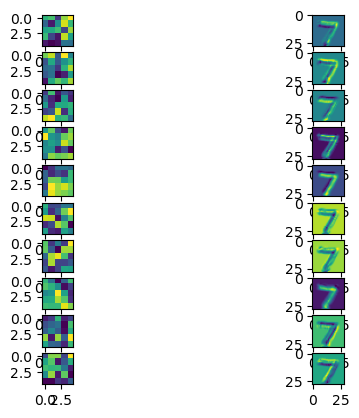

In [32]:
visualize()

Using 3,000 images instead of 60,000 further decreases the accuracy - going from a maximum accuracy of 98% to 83%. 

In [33]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [34]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_33793/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.298841
Test accuracy: 10%

Train loss: 2.313027
Test accuracy: 12%

Train loss: 2.295386
Test accuracy: 18%

Train loss: 2.290891
Test accuracy: 20%

Train loss: 2.260220
Test accuracy: 24%



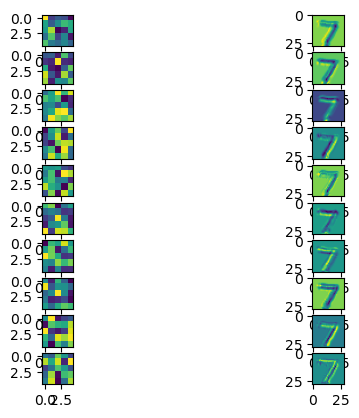

In [35]:
visualize()

Using 600 images instead of 60,000 completely diminishes the accuracy - going from a maximum accuracy of 98% to 24%. This is now more inaccurate than it is accurate.

- 1b. How do the weights looks different when trained with 60,000 vs 600?
The weighting appears less "clustered" in the 600 image-trained network, with quite a bit more variation in color patterning. In the 60,000 image-trained network, the weighting appears very consistently clustered and the color distribution appears more unchanging.